## Analyze A/B Test Results

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.

This project works to understand the results of an A/B test run by an e-commerce website.  The goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

##### Let's explore the data

In [2]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the below cell to find the number of rows in the dataset.

In [3]:
df.shape

(294478, 5)

c. The number of unique users in the dataset.

In [4]:
df.user_id.nunique()

290584

d. The proportion of users converted.

In [5]:
df.converted.mean()

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't line up.

In [6]:
df.query('group == "treatment" and landing_page != "new_page"').count()[0] + df.query('group == "control" and landing_page == "new_page"').count()[0]

3893

f. Do any of the rows have missing values?

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


`2.` For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to provide how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [8]:
# Drop all columns where the treatment is not with new_page and control is not aligned iwth old_page
index_names = df.query('(group == "treatment" and landing_page != "new_page") or (group == "control" and landing_page == "new_page")').index
df2 = df.drop(index_names)
df2.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [9]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [10]:
df2.user_id.nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [11]:
df2[df2.duplicated(['user_id'], keep = False)]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


c. What is the row information for the repeat **user_id**? 

The above code shows both repeated user_id and the row information for both instances of the user.

d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [12]:
df2.drop_duplicates(keep = 'last')

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1
...,...,...,...,...,...
294473,751197,2017-01-03 22:28:38.630509,control,old_page,0
294474,945152,2017-01-12 00:51:57.078372,control,old_page,0
294475,734608,2017-01-22 11:45:03.439544,control,old_page,0
294476,697314,2017-01-15 01:20:28.957438,control,old_page,0


In [13]:
# Confirm duplicate row was dropped
df2[df2.duplicated(['user_id'], keep = False)]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


`4.` Use **df2** in the below cells to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [14]:
df2.query('converted == 1').shape[0] / df2.converted.shape[0]

0.11959667567149027

b. Given that an individual was in the `control` group, what is the probability they converted?

In [15]:
df2.query('group == "control" and converted == 1').shape[0] / df2.query('group == "control"').shape[0]

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [16]:
df2.query('group == "treatment" and converted == 1').shape[0] / df2.query('group == "treatment"').shape[0]

0.11880724790277405

d. What is the probability that an individual received the new page?

In [17]:
df2.query('landing_page == "new_page"').shape[0] / df2.landing_page.shape[0]

0.5000636646764286

e. Consider your results from a. through d. above, and explain below whether you think there is sufficient evidence to say that the new treatment page leads to more conversions.

The probability of conversion given an individual is in the treatment group is ~11.88% which is lower than the control group's conversion of ~12.04%.  Just based on the probability, there is not sufficient evidence to say that the new treament page leads to more conversions.

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

$$H_0: p_{new} - p_{old} \leq 0$$

$$H_1: p_{new} - p_{old} \gt 0$$

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **convert rate** for $p_{new}$ under the null? 

In [18]:
p_new = df2.converted.mean()
p_new

0.11959667567149027

b. What is the **convert rate** for $p_{old}$ under the null? <br><br>

In [19]:
p_old = df2.converted.mean()
p_old

0.11959667567149027

c. What is $n_{new}$?

In [20]:
n_new = df2.query('group == "treatment"').shape[0]
n_new

145311

d. What is $n_{old}$?

In [21]:
n_old = df2.query('group == "control"').shape[0]
n_old

145274

e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [22]:
new_page_converted = np.random.choice([0, 1], size=n_new, p=[p_new, 1-p_new])
new_page_converted

array([1, 0, 1, ..., 1, 0, 1])

f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [23]:
old_page_converted = np.random.choice([0, 1], size=n_old, p=[p_old, 1-p_old])
old_page_converted

array([1, 1, 1, ..., 0, 1, 1])

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [24]:
obs_diff = new_page_converted.mean() - old_page_converted.mean()
obs_diff

0.0015721748062191843

h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in a numpy array called **p_diffs**.

In [25]:
p_diffs = []

for _ in range(10000):
    new_page_converted = np.random.binomial(1, p_new, n_new)        
    old_page_converted = np.random.binomial(1, p_old, n_old)
    temp_new = new_page_converted.mean()
    temp_old = old_page_converted.mean()
    p_diffs.append(temp_new - temp_old)
    
p_diffs = np.array(p_diffs)
p_diffs

array([ 0.00080241,  0.0006438 , -0.00142059, ..., -0.00081469,
       -0.00145525,  0.00228186])

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

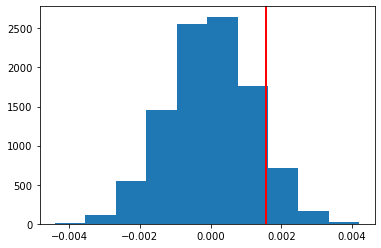

In [26]:
plt.hist(p_diffs)
plt.axvline(obs_diff,color='r', linewidth=2)

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [27]:
(p_diffs > obs_diff).mean()

0.0983

k. In words, explain what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

In part j, the value calculated is the p-value, which is the proportion of p_diffs (simulated sampling difference) that are consistent with actual observed conversion rates (obs_diffs).  Since the value is greater than the type I error rate of 0.05 then we cannot reject null hypothesis.



l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [28]:
import statsmodels.api as sm

convert_old = df2.query('group == "control"').converted.sum()
convert_new = df2.query('group == "treatment"').converted.sum()
n_old = df2.query('group == "control"').shape[0]
n_new = df2.query('group =="treatment"').shape[0]

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [29]:
count_array = np.array([convert_new, convert_old])
nobs_array = np.array([n_old, n_new])

z_score, p_value = sm.stats.proportions_ztest(count_array, nobs_array, alternative='larger')
z_score, p_value

(-1.261011806479853, 0.8963477032758391)

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

The computed z-score and p-value values mean the conversion rates for the new pages are not statistically higher than they are for the old pages.  They agree with the findings in parts **j.** and **k.**

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you acheived in the previous A/B test can also be acheived by performing regression.<br><br>

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

The type of regression performed in this case is a logistic regression.

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.  However, you first need to create a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [30]:
df_reg = df2
df_reg['intercept'] = 1
df_reg[['control', 'ab_page']] = pd.get_dummies(df_reg['group'])
df_reg.drop('control', axis = 1, inplace = True)
df_reg.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


c. Use **statsmodels** to import your regression model.  Instantiate the model, and fit the model using the two columns you created in part **b.** to predict whether or not an individual converts.

In [31]:
results = sm.Logit(df_reg['converted'], df_reg[['intercept', 'ab_page']]).fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [32]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290585
Model:                          Logit   Df Residuals:                   290583
Method:                           MLE   Df Model:                            1
Date:                Wed, 06 Jul 2022   Pseudo R-squ.:               8.085e-06
Time:                        15:21:25   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1897
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.312      0.190      -0.037       0.007
==============================================================================
"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in the **Part II**?

The p-value associated with ab_page is 0.190.  This differs from the one found in Part II as the regression model assumes a 2-tail test with hypotheses:

$$H_0: p_{new} = p_{old} $$

$$H_1: p_{new} \neq p_{old} $$

Part II is a one-tail test.

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

The above regression just analyzes if people with the new/old page convert or not.  This assumes are fairly simple relationship but is most like more complex and the result could be biased through omission.

Adding additional terms to the regression model can result multicolinearity where the terms added and the terms are correlated to each other.

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives. You will need to read in the **countries.csv** dataset and merge together your datasets on the approporiate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [33]:
countries_df = pd.read_csv('./countries.csv')
df_new = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')
df_new.country.unique()

array(['US', 'UK', 'CA'], dtype=object)

In [34]:
### Create the necessary dummy variables
df_new[['CA', 'UK', 'US']] = pd.get_dummies(df_new['country'])
df_new['US_ab_page'] = df_new['US'] * df_new['ab_page']
df_new['CA_ab_page'] = df_new['CA'] * df_new['ab_page']
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page,CA,UK,US,US_ab_page,CA_ab_page
user_id,,,,,,,,,,,,
630000,US,2017-01-19 06:26:06.548941,treatment,new_page,0,1,1,0,0,1,1,0
630001,US,2017-01-16 03:16:42.560309,treatment,new_page,1,1,1,0,0,1,1,0
630002,US,2017-01-19 19:20:56.438330,control,old_page,0,1,0,0,0,1,0,0
630003,US,2017-01-12 10:09:31.510471,treatment,new_page,0,1,1,0,0,1,1,0
630004,US,2017-01-18 20:23:58.824994,treatment,new_page,0,1,1,0,0,1,1,0


h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [35]:
### Fit Your Linear Model And Obtain the Results
results_new = sm.Logit(df_new['converted'], df_new[['intercept', 'ab_page', 'US', 'CA', 'US_ab_page', 'CA_ab_page']]).fit()
results_new.summary2()

Optimization terminated successfully.
         Current function value: 0.366108
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212782.9124
Date:               2022-07-06 15:21 BIC:              212846.3903
No. Observations:   290585           Log-Likelihood:   -1.0639e+05
Df Model:           5                LL-Null:          -1.0639e+05
Df Residuals:       290579           LLR p-value:      0.19182    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9922    0.0161  -123.4571  0.0000  -2.0238  -1.9606
ab_page       0.0108    0.0228     0.4749  0.6349  -0.0339   0.0555
US            0.0057    0.0188     0.3057  0.7598  -0.0311   0.0426
CA           -0.0118    0.0398    -0.2957  0.7674  -0.0899   0.0663
US_ab_page   -0.0314    0.0266    -1.1811  0.2375  -0.0835   0.0207
CA_ab_page   -0.0783    0.0568    -1.3783  0.1681  -0.1896   0.0330
==================================================================

"""

In [36]:
np.exp(0.0057), 1/np.exp(-0.0118)

(1.0057162759095335, 1.011869894648401)

Higher order terms make the prediction of the model better at the expense of interpretation of the coefficients.  Based on the exponated coefficients, the US has a 1.0057 times higher conversion rate compared to CA holding all other variables constant.  Similarly, CA has a 1.0119 times lower conversaion rate chance compared 

Since the p-values are higher than 0.05, the null hypothesis does not get rejected and country does not have a large impact on conversion.

<a id='conclusions'></a>
## Conclusions

We analyzed 3 different ways to see if the site's new page results in a higher conversion:
1. Probability: we calculated the probability that the new page resulted in a higher conversion rate.  In this analysis, the treatment group is ~11.88% which is lower than the control group's conversion of ~12.04%.
2. A/B test: in this test, we calculated the p-value as the difference the observed conversion rate mean and a sampled conversion rate mean.  This resulted in a p-value larger than 0.05 so the null hypothesis could not be rejected.
3. Regression: we modeled the data using logistic regression.  We created a multivariable regression using the countries of the users.  We found that the user's country has no impact on the conversion.

The final conclusion that the new page has no impact on the conversion rate and should be be adopted by the company.

### Resources:

https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.drop.html

https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.duplicated.html

https://stackoverflow.com/questions/14657241/how-do-i-get-a-list-of-all-the-duplicate-items-using-pandas-in-python

https://knowledge.udacity.com/questions/740440